In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import os
import kagglehub
import math
import random
import matplotlib.pyplot as plt

c:\Users\vk200\Pictures\Side projects\Satellite Image Classification\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 10
num_classes = 10  # adjust if EuroSAT has more classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# KaggleHub path to EuroSAT images
path = kagglehub.dataset_download("apollo2506/eurosat-dataset")
print(path)

C:\Users\vk200\.cache\kagglehub\datasets\apollo2506\eurosat-dataset\versions\6


In [5]:

# Path to your CSV
csv_path = path+"/EuroSAT/train.csv"

# Load the CSV
df = pd.read_csv(csv_path)
img_path = path+"/EuroSAT/"+df.iloc[0,1]
label_path = path+"/EuroSAT/"+str(df.iloc[0,2])

# Define transformation pipeline
transform = transforms.Compose([
    transforms.Resize((64, 64)),    # Resize to 64x64 if needed
    transforms.ToTensor()           # Converts to tensor & scales to [0,1]
])

# Load image and force RGB
img = Image.open(img_path).convert("RGB")

# Apply transform
tensor_img = transform(img)

In [6]:
# Custom dataset for EuroSAT
class EuroSATDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 1])  # filename column
        label = int(self.df.iloc[idx, 2])  # label column

        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label


# Transform pipeline
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Train & test datasets
train_dataset = EuroSATDataset(
    csv_file=os.path.join(path, "EuroSAT", "train.csv"),
    root_dir=os.path.join(path, "EuroSAT"),
    transform=transform
)

test_dataset = EuroSATDataset(
    csv_file=os.path.join(path, "EuroSAT", "test.csv"),
    root_dir=os.path.join(path, "EuroSAT"),
    transform=transform
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [7]:

class CNN64x64(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN64x64, self).__init__()

        # ---- Convolutional layers ----
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  # 64x64 -> 64x64
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)                                      # 64x64 -> 64x64
        self.pool = nn.MaxPool2d(2, 2)                                                   # 64x64 -> 32x32

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)                                     # 32x32 -> 32x32
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)                                    # 32x32 -> 32x32
        self.pool2 = nn.MaxPool2d(2, 2)                                                  # 32x32 -> 16x16

        # ---- Fully connected layers ----
        self.fc1 = nn.Linear(256*16*16, 512)  # flatten
        self.fc2 = nn.Linear(512, num_classes)

        # Activation
        self.relu = nn.ReLU()
        # Optional dropout to prevent overfitting
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # First block
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # Second block
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool2(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [8]:
model = CNN64x64(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()            # suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
print("------Started!!------")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_batches = len(train_loader)
    progress_interval = math.ceil(total_batches / 10)  # every 10%

    for batch_idx, (images, labels) in enumerate(train_loader, 1):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print progress every 10%
        if batch_idx % progress_interval == 0 or batch_idx == total_batches:
            avg_loss = running_loss / batch_idx
            progress_percent = int(batch_idx / total_batches * 100)
            print(f"Epoch [{epoch+1}/{num_epochs}], Progress: {progress_percent}%, Avg Loss: {avg_loss:.4f}")


print("------------------------")
print("---------DONE!!---------")
print("------------------------")


------Started!!------
Epoch [1/10], Progress: 10%, Avg Loss: 2.0006
Epoch [1/10], Progress: 20%, Avg Loss: 1.8962
Epoch [1/10], Progress: 30%, Avg Loss: 1.8623
Epoch [1/10], Progress: 40%, Avg Loss: 1.8128
Epoch [1/10], Progress: 50%, Avg Loss: 1.7494
Epoch [1/10], Progress: 60%, Avg Loss: 1.6831
Epoch [1/10], Progress: 71%, Avg Loss: 1.6207
Epoch [1/10], Progress: 81%, Avg Loss: 1.5607
Epoch [1/10], Progress: 91%, Avg Loss: 1.5061
Epoch [1/10], Progress: 100%, Avg Loss: 1.4636
Epoch [2/10], Progress: 10%, Avg Loss: 1.0400
Epoch [2/10], Progress: 20%, Avg Loss: 1.0162
Epoch [2/10], Progress: 30%, Avg Loss: 0.9832
Epoch [2/10], Progress: 40%, Avg Loss: 0.9715
Epoch [2/10], Progress: 50%, Avg Loss: 0.9503
Epoch [2/10], Progress: 60%, Avg Loss: 0.9344
Epoch [2/10], Progress: 71%, Avg Loss: 0.9221
Epoch [2/10], Progress: 81%, Avg Loss: 0.9043
Epoch [2/10], Progress: 91%, Avg Loss: 0.8910
Epoch [2/10], Progress: 100%, Avg Loss: 0.8775
Epoch [3/10], Progress: 10%, Avg Loss: 0.7194
Epoch [3/1

In [10]:
torch.save(model.state_dict(), "eurosat_cnn64x64.pth")
print("Model saved as eurosat_cnn64x64.pth")

Model saved as eurosat_cnn64x64.pth


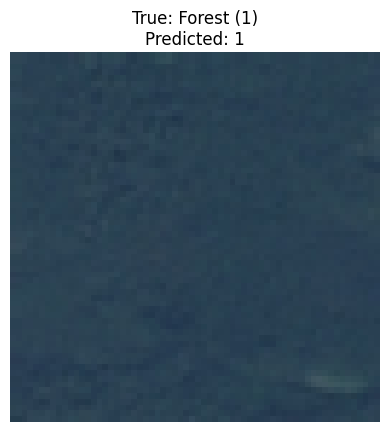


Class probabilities:
0 : 0.0%
1 : 100.0%
2 : 0.0%
3 : 0.0%
4 : 0.0%
5 : 0.0%
6 : 0.0%
7 : 0.0%
8 : 0.0%
9 : 0.0%


In [33]:
# Load test.csv
test_csv_path = path + "/EuroSAT/test.csv"
test_df = pd.read_csv(test_csv_path)

# Pick a random index
rand_idx = random.randint(0, len(test_df) - 1)

# Get file path & label
img_path = os.path.join(path, "EuroSAT", test_df.iloc[rand_idx, 1])
true_label = test_df.iloc[rand_idx, 2]          # integer label
class_name = test_df.iloc[rand_idx, 3]          # class name column

# Load and preprocess image
img = Image.open(img_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0)  # [1, 3, 64, 64]

# Put model in eval mode and run prediction
model.eval()
with torch.no_grad():
    outputs = model(img_tensor)  # raw logits
    probs = torch.softmax(outputs, dim=1).squeeze()  # remove batch dim
    _, predicted = torch.max(outputs, 1)
    predicted_label = predicted.item()

# Show image
plt.imshow(img)
plt.axis('off')
plt.title(f"True: {class_name} ({true_label})\nPredicted: {predicted_label}")
plt.show()

# Print probabilities in "index : percentage%" format
print("\nClass probabilities:")
for idx, prob in enumerate(probs):
    print(f"{idx} : {prob.item() * 100:.1f}%")


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
# Move model to device
model = model.to(device)

# Accuracy check
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # no .data needed
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 86.74%
